## Pip Installs and Imports

In [1]:
#! pip install convokit


In [2]:
from convokit import Corpus, download
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [3]:
#nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
#nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Explorative Data Anlyses

In [5]:
corpus = Corpus(filename=download("movie-corpus"))

In [6]:
corpus.print_summary_stats()

Number of Speakers: 9035
Number of Utterances: 304713
Number of Conversations: 83097


In [7]:
utterances = corpus.get_utterances_dataframe()

In [8]:
utterances.head()

,timestamp,text,speaker,reply_to,conversation_id,meta.movie_id,meta.parsed,vectors
id,,,,,,,,
L1045,None,They do not!,u0,L1044,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[]
L1044,None,They do to!,u2,None,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[]
L985,None,I hope so.,u0,L984,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'I', 'tag': 'PRP',...",[]
L984,None,She okay?,u2,None,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'She', 'tag': 'PRP...",[]
L925,None,Let's go.,u0,L924,L924,m0,"[{'rt': 0, 'toks': [{'tok': 'Let', 'tag': 'VB'...",[]


In [9]:
utterances.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304713 entries, L1045 to L666256
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   timestamp        0 non-null       object
 1   text             304713 non-null  object
 2   speaker          304713 non-null  object
 3   reply_to         221616 non-null  object
 4   conversation_id  304713 non-null  object
 5   meta.movie_id    304713 non-null  object
 6   meta.parsed      304713 non-null  object
 7   vectors          304713 non-null  object
dtypes: object(8)
memory usage: 20.9+ MB


In [10]:
conversations = corpus.get_conversations_dataframe()

In [11]:
conversations.head()

,vectors,meta.movie_idx,meta.movie_name,meta.release_year,meta.rating,meta.votes,meta.genre
id,,,,,,,
L1044,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L984,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L924,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L870,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L866,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"


In [12]:
conversations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83097 entries, L1044 to L666256
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   vectors            83097 non-null  object
 1   meta.movie_idx     83097 non-null  object
 2   meta.movie_name    83097 non-null  object
 3   meta.release_year  83097 non-null  object
 4   meta.rating        83097 non-null  object
 5   meta.votes         83097 non-null  object
 6   meta.genre         83097 non-null  object
dtypes: object(7)
memory usage: 5.1+ MB


In [13]:
conversations.describe()

,vectors,meta.movie_idx,meta.movie_name,meta.release_year,meta.rating,meta.votes,meta.genre
count,83097,83097,83097,83097,83097,83097,83097
unique,1,617,617,88,62,614,290
top,[],m289,casino,1999,7.20,111223,['drama']
freq,83097,338,338,6646,3694,338,5027


## Choosing only one meta.genre for movie

In [14]:
! pip install openpyxl


'pip' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
from openpyxl.workbook import Workbook

# Downloading conversations as an excel 
with pd.ExcelWriter('movies_data.xlsx') as writer:
    conversations.to_excel(writer, sheet_name='Conversations', index=False)

print("Data saved to movies_data.xlsx")

# From here the dataset can be modified manually choosing only one genre from the list in mets.genre
# The choice can be more accurate because one genre is often prominent in a movie and a human can detect it but time consuming

Data saved to movies_data.xlsx


In [16]:
# Other way to proceed is automatization so to choose only first genre
# Function to extract the first genre

def extract_first_genre(meta_genre):
    if isinstance(meta_genre, str) and meta_genre.startswith('[') and meta_genre.endswith(']'):
        genres = meta_genre.strip("[]").replace("'", "").split(", ") # Creates a proper python list
        if genres:
            return genres[0] # Takes only the first element of the list
    return meta_genre

# Apply the function to the 'meta.genre' column
conversations['meta.genre'] = conversations['meta.genre'].apply(extract_first_genre)

conversations.head()

,vectors,meta.movie_idx,meta.movie_name,meta.release_year,meta.rating,meta.votes,meta.genre
id,,,,,,,
L1044,[],m0,10 things i hate about you,1999,6.90,62847,comedy
L984,[],m0,10 things i hate about you,1999,6.90,62847,comedy
L924,[],m0,10 things i hate about you,1999,6.90,62847,comedy
L870,[],m0,10 things i hate about you,1999,6.90,62847,comedy
L866,[],m0,10 things i hate about you,1999,6.90,62847,comedy


In [17]:
conversations.describe()

,vectors,meta.movie_idx,meta.movie_name,meta.release_year,meta.rating,meta.votes,meta.genre
count,83097,83097,83097,83097,83097,83097,83097
unique,1,617,617,88,62,614,18
top,[],m289,casino,1999,7.20,111223,action
freq,83097,338,338,6646,3694,338,18998


## Merge the Dataframes

In [18]:
# Merge the DataFrames on 'conversation_id' from utterances and 'id' from conversations
merged_df = pd.merge(utterances, conversations, left_on='conversation_id', right_on='id', suffixes=('_utterance', '_conversation'))
merged_df.head()

,timestamp,text,speaker,reply_to,conversation_id,meta.movie_id,meta.parsed,vectors_utterance,vectors_conversation,meta.movie_idx,meta.movie_name,meta.release_year,meta.rating,meta.votes,meta.genre
0,None,They do not!,u0,L1044,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[],[],m0,10 things i hate about you,1999,6.90,62847,comedy
1,None,They do to!,u2,None,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[],[],m0,10 things i hate about you,1999,6.90,62847,comedy
2,None,I hope so.,u0,L984,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'I', 'tag': 'PRP',...",[],[],m0,10 things i hate about you,1999,6.90,62847,comedy
3,None,She okay?,u2,None,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'She', 'tag': 'PRP...",[],[],m0,10 things i hate about you,1999,6.90,62847,comedy
4,None,Let's go.,u0,L924,L924,m0,"[{'rt': 0, 'toks': [{'tok': 'Let', 'tag': 'VB'...",[],[],m0,10 things i hate about you,1999,6.90,62847,comedy


In [19]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304713 entries, 0 to 304712
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   timestamp             0 non-null       object
 1   text                  304713 non-null  object
 2   speaker               304713 non-null  object
 3   reply_to              221616 non-null  object
 4   conversation_id       304713 non-null  object
 5   meta.movie_id         304713 non-null  object
 6   meta.parsed           304713 non-null  object
 7   vectors_utterance     304713 non-null  object
 8   vectors_conversation  304713 non-null  object
 9   meta.movie_idx        304713 non-null  object
 10  meta.movie_name       304713 non-null  object
 11  meta.release_year     304713 non-null  object
 12  meta.rating           304713 non-null  object
 13  meta.votes            304713 non-null  object
 14  meta.genre            304713 non-null  object
dtypes: object(15)
mem

In [20]:
merged_df['meta.rating'] = pd.to_numeric(merged_df['meta.rating'], errors='coerce')
merged_df['meta.votes'] = pd.to_numeric(merged_df['meta.votes'], errors='coerce')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304713 entries, 0 to 304712
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   timestamp             0 non-null       object 
 1   text                  304713 non-null  object 
 2   speaker               304713 non-null  object 
 3   reply_to              221616 non-null  object 
 4   conversation_id       304713 non-null  object 
 5   meta.movie_id         304713 non-null  object 
 6   meta.parsed           304713 non-null  object 
 7   vectors_utterance     304713 non-null  object 
 8   vectors_conversation  304713 non-null  object 
 9   meta.movie_idx        304713 non-null  object 
 10  meta.movie_name       304713 non-null  object 
 11  meta.release_year     304713 non-null  object 
 12  meta.rating           304713 non-null  float64
 13  meta.votes            304713 non-null  int64  
 14  meta.genre            304713 non-null  object 
dtype

## Checking for empty genres

In [21]:
merged_df['meta.genre'].unique()

array(['comedy', 'adventure', 'action', 'crime', 'fantasy', 'sci-fi',
       'drama', 'biography', 'horror', 'animation', 'thriller', 'mystery',
       '', 'short', 'family', 'romance', 'documentary', 'film-noir'],
      dtype=object)

In [22]:
empty_genre_rows = merged_df[merged_df['meta.genre'] == ''].count()
print("Rows with empty genre:")
print(empty_genre_rows)

Rows with empty genre:
timestamp                 0
text                    359
speaker                 359
reply_to                248
conversation_id         359
meta.movie_id           359
meta.parsed             359
vectors_utterance       359
vectors_conversation    359
meta.movie_idx          359
meta.movie_name         359
meta.release_year       359
meta.rating             359
meta.votes              359
meta.genre              359
dtype: int64


In [23]:
merged_df['meta.genre'] = merged_df['meta.genre'].replace('', 'Undetected')
merged_df['meta.genre'].unique()

array(['comedy', 'adventure', 'action', 'crime', 'fantasy', 'sci-fi',
       'drama', 'biography', 'horror', 'animation', 'thriller', 'mystery',
       'Undetected', 'short', 'family', 'romance', 'documentary',
       'film-noir'], dtype=object)

## Visualizations of the Data

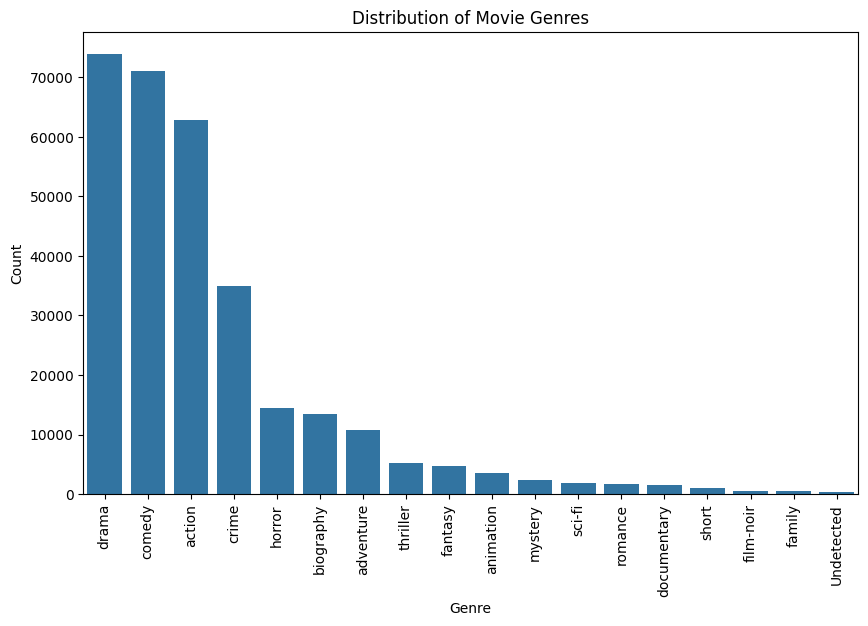

In [24]:
# Distribution of movie genres
genre_counts = merged_df['meta.genre'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

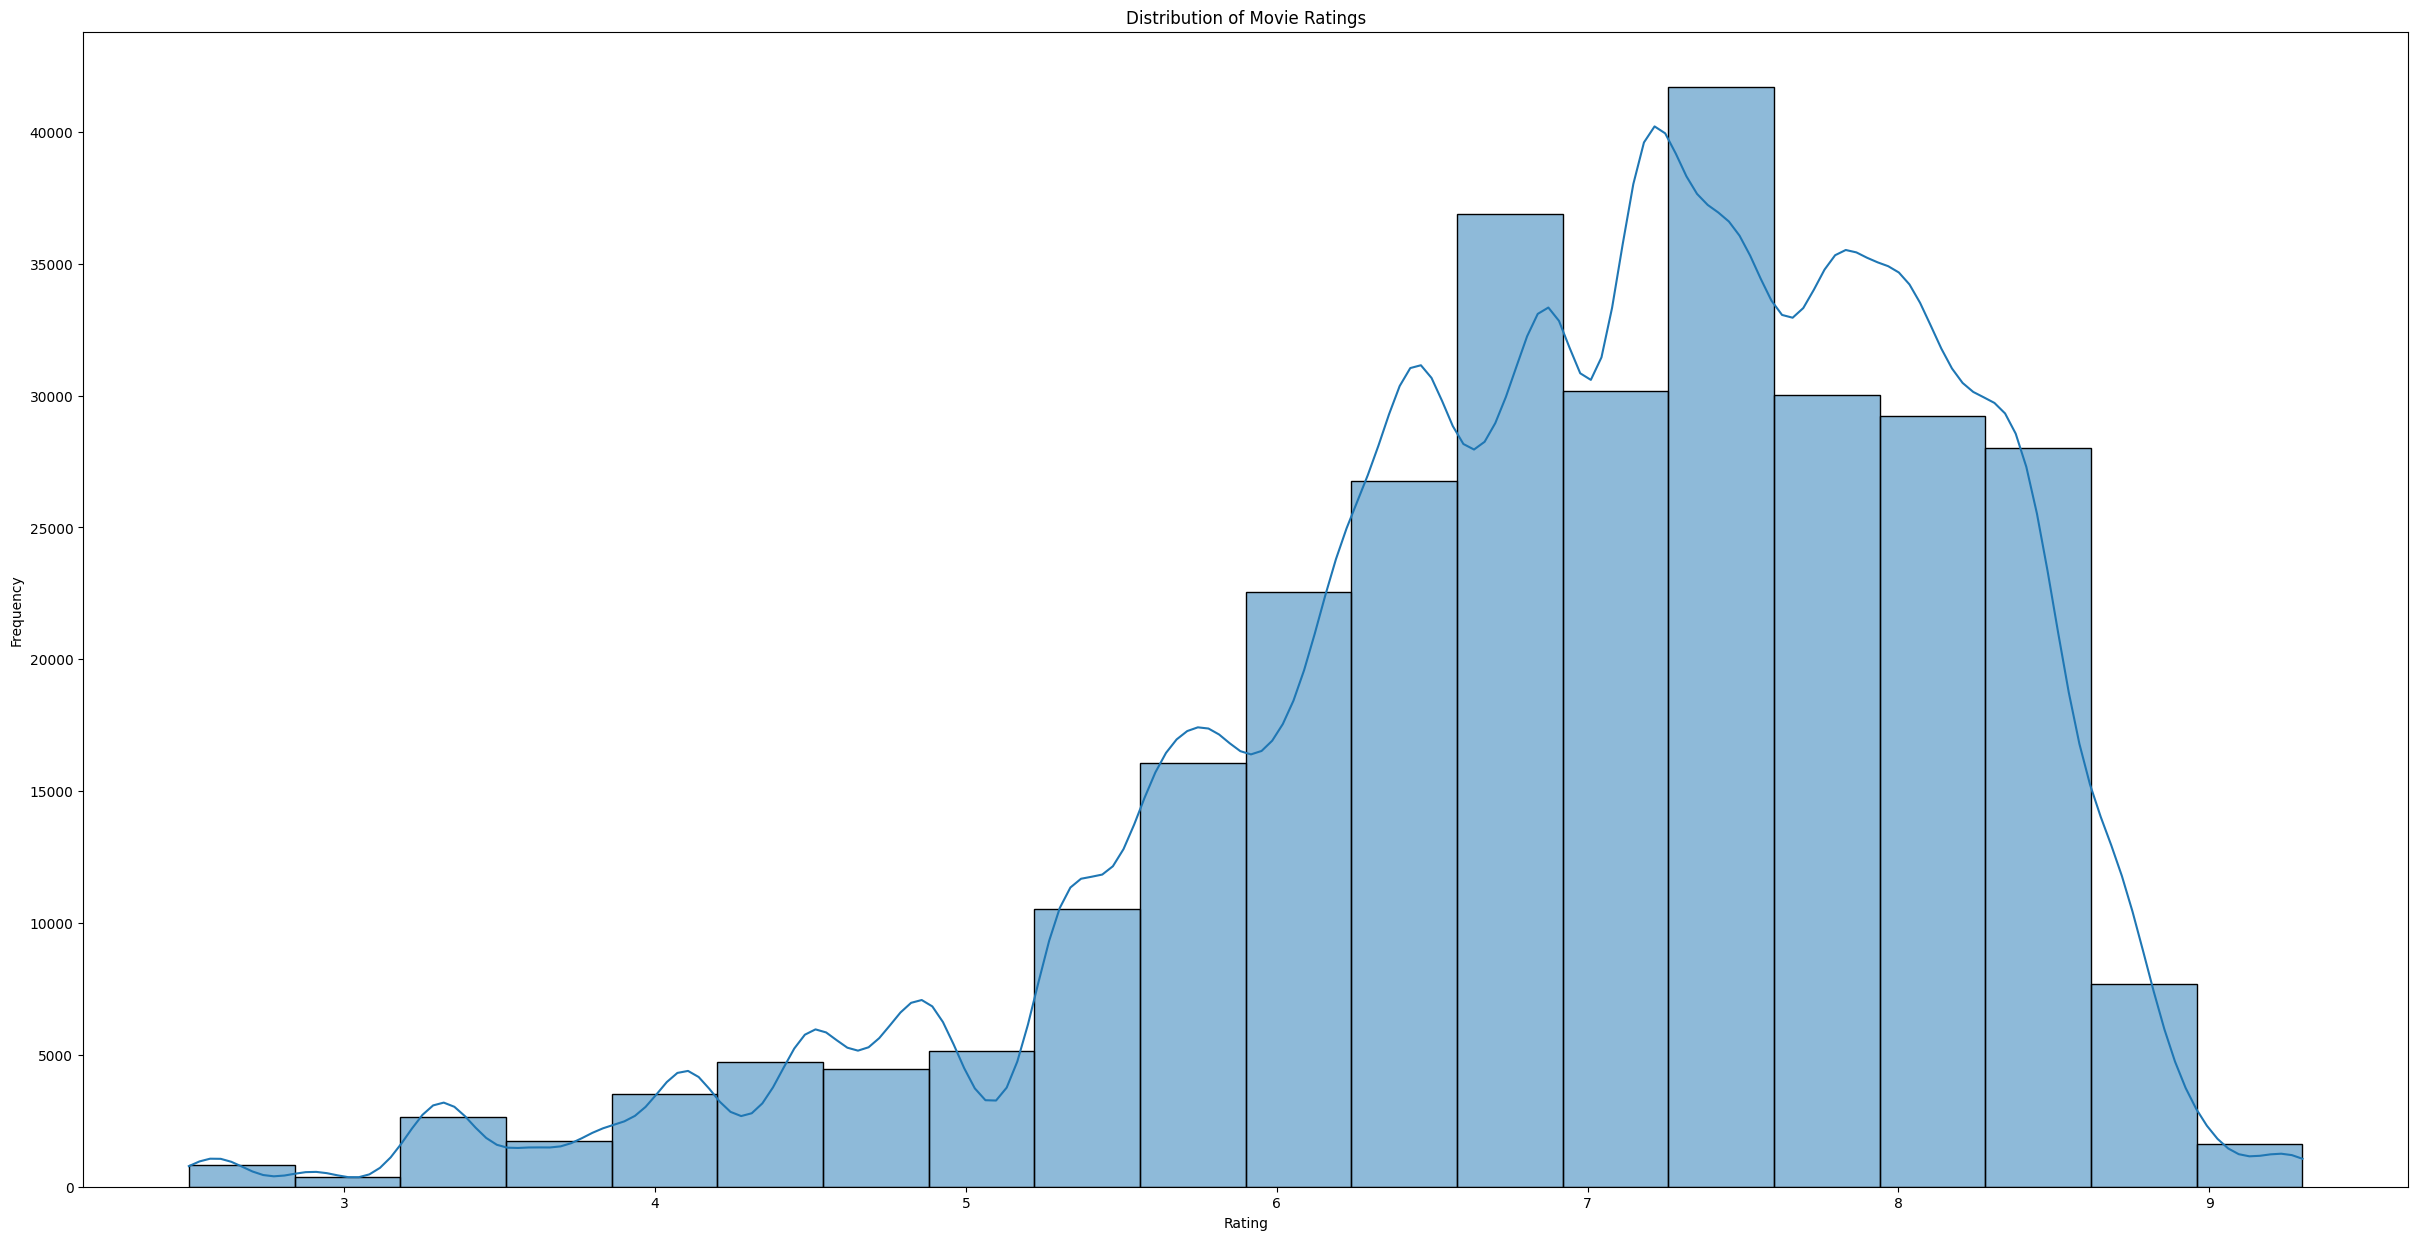

In [25]:
# Ratings Distribution 
plt.figure(figsize=(30, 15))
sns.histplot(merged_df['meta.rating'], bins=20, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Conversations per movie to show some movies present more conversations than others
conversations_per_movie = merged_df['meta.movie_name'].value_counts()

plt.figure(figsize=(100,85))
sns.barplot(x=conversations_per_movie.index, y=conversations_per_movie.values)
plt.title('Number of Conversations per Movie')
plt.xlabel('Movie')
plt.ylabel('Number of Conversations')
plt.xticks(rotation=90)
plt.show()

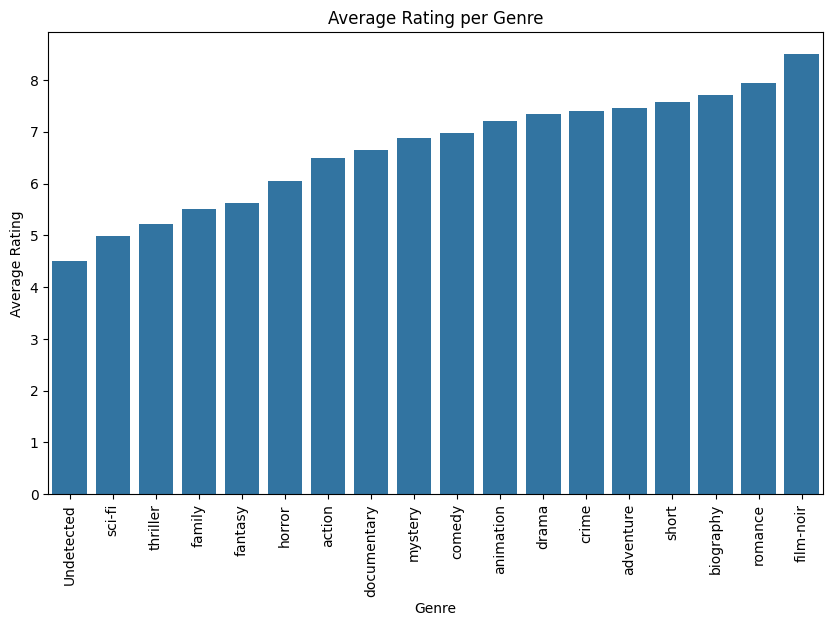

In [27]:
# Average rating per genre
average_rating_per_genre = merged_df.groupby('meta.genre')['meta.rating'].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=average_rating_per_genre.index, y=average_rating_per_genre.values)
plt.title('Average Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.show()

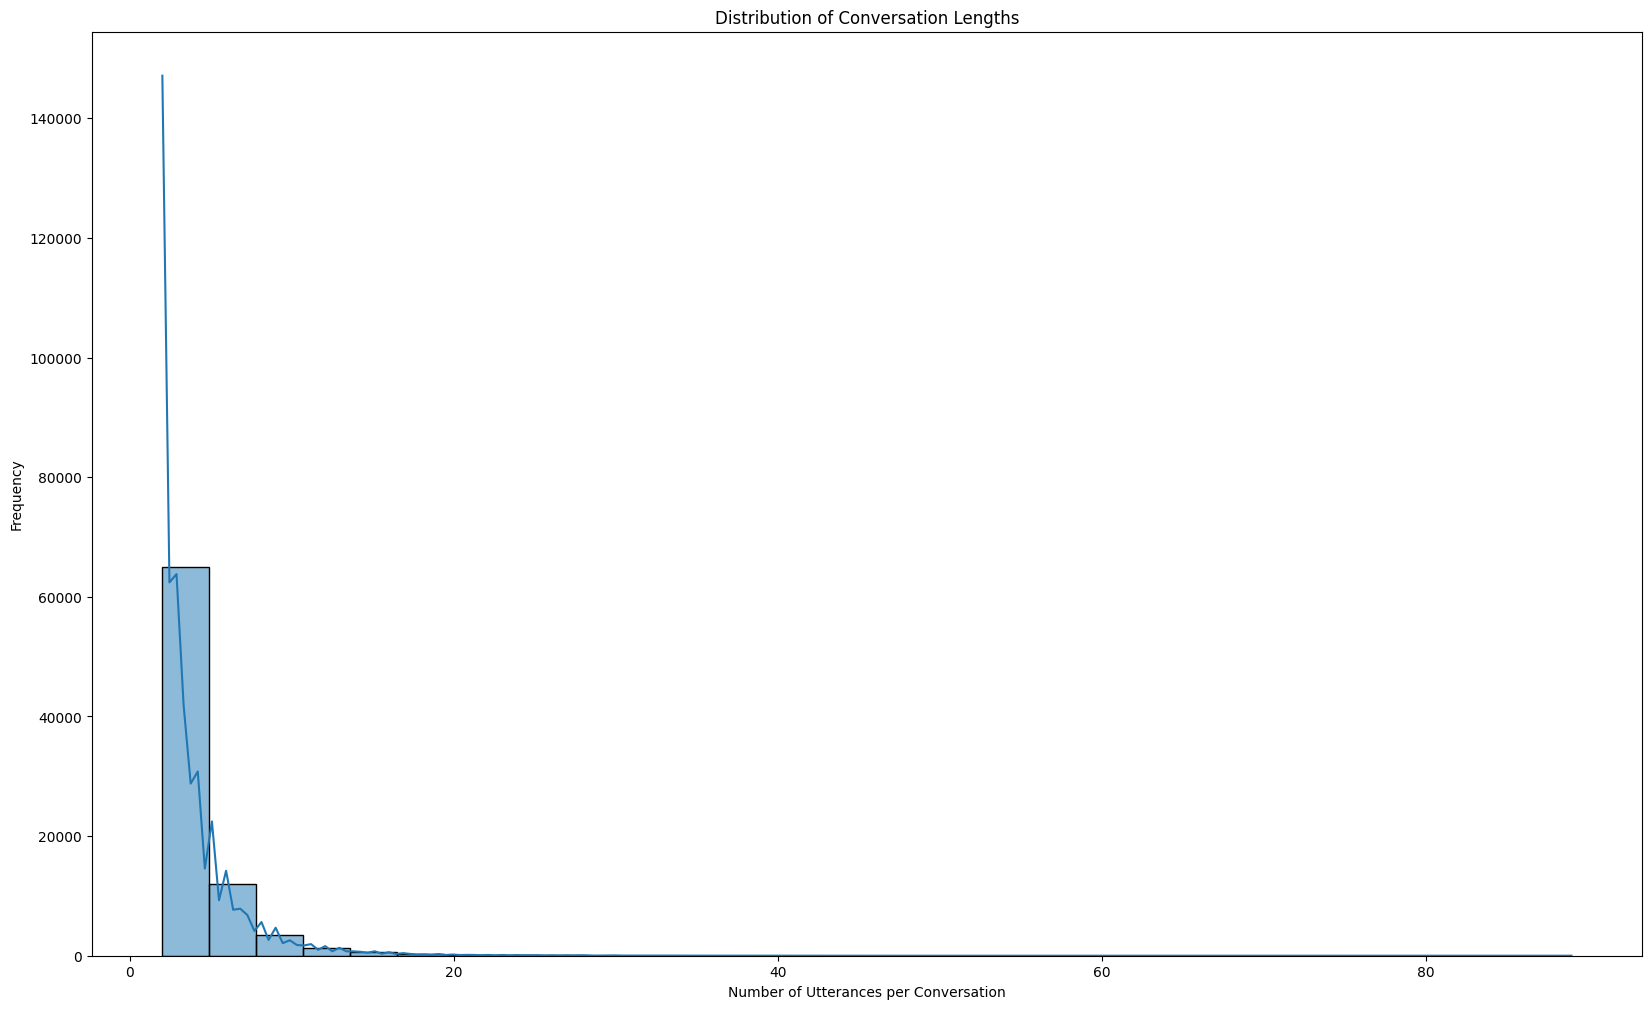

In [28]:
# Conversations lenghts
conversation_lengths = merged_df['conversation_id'].value_counts()

plt.figure(figsize=(20, 12))
sns.histplot(conversation_lengths, bins=30, kde=True)
plt.title('Distribution of Conversation Lengths')
plt.xlabel('Number of Utterances per Conversation')
plt.ylabel('Frequency')
plt.show()


In [29]:
merged_df['meta.genre'].isnull().sum()

0

# Pre-processing

In [30]:
s = stopwords.words('english')
# stopwords is a list of must commun english words
s.extend([',' , '.' , '?' , ',' , ',' ,':' ,';',"'", '“', '”', '!', '’','...', '....','--', '_'])

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    # Lemmatize each word in the tokenized text
    text = [lemmatizer.lemmatize(word) for word in text]
    text = [word for word in text if word not in s and not any(char.isdigit() for char in word)]
    return ' '.join(text)

In [31]:
merged_df['Processed_Text'] = merged_df['text'].apply(preprocess_text)

In [32]:
merged_df['Processed_Text']

0                                                          
1                                                          
2                                                      hope
3                                                      okay
4                                                    let go
                                ...                        
304708          lord chelmsford seems want stay back basuto
304709                     im take sikali main column river
304710                                     order mr vereker
304711         good one yes mr vereker gentleman ride shoot
304712    colonel durnford william vereker hear seeking ...
Name: Processed_Text, Length: 304713, dtype: object

# Naive Bayes Method

Vectorization

In [33]:
# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000) 
X = vectorizer.fit_transform(merged_df['Processed_Text']).toarray()

Encoding

In [34]:
# Encoding the labels
le = LabelEncoder()
y = le.fit_transform(merged_df['meta.genre'])

Train the Model

In [35]:
# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Naive Bayers 
# Initialize the Multinomial Naive Bayes classifier
nb_clf = MultinomialNB()
# Train the classifier
nb_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

# Make predictions on the test set
nb_y_pred = nb_clf.predict(X_test)

# Calculate accuracy, precision, recall, and F1-score of the model
accuracy = accuracy_score(y_test, nb_y_pred)
precision = precision_score(y_test, nb_y_pred, average='weighted')  
recall = recall_score(y_test, nb_y_pred, average='weighted')       
f1 = f1_score(y_test, nb_y_pred, average='weighted')                
print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

C:\Users\joda\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Accuracy: 0.3366424363749733
Precision: 0.42645399454621463
Recall: 0.3366424363749733
F1-Score: 0.2891253277677531


# Logistic Regression

In [38]:
import time
# Start the timer for the entire process
start_time = time.time()

# Logistic Regression classifier
lr_clr = LogisticRegression(n_jobs=-1) 
lr_clr.fit(X_train, y_train)

# Predictions
lr_y_pred = lr_clr.predict(X_test)

# Calculate accuracy, precision, recall, and F1-score of the model
accuracy = accuracy_score(y_test, lr_y_pred)
precision = precision_score(y_test, lr_y_pred, average='weighted')
recall = recall_score(y_test, lr_y_pred, average='weighted')
f1 = f1_score(y_test, lr_y_pred, average='weighted')

print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# End the timer for the entire process
end_time = time.time()

# Calculate the total elapsed time
total_time = end_time - start_time
print(f"Total Execution Time: {total_time} seconds")

In [ ]:
# Logistic with sample of dataset

import time
# Start the timer for the entire process
start_time = time.time()

X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.50, random_state=42)

# Further split the sampled data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Logistic Regression classifier
lr_clr = LogisticRegression(n_jobs=-1)
lr_clr.fit(X_train, y_train)

# Predictions
lr_y_pred = lr_clr.predict(X_test)

# Calculate accuracy, precision, recall, and F1-score of the model
accuracy = accuracy_score(y_test, lr_y_pred)
precision = precision_score(y_test, lr_y_pred, average='weighted')
recall = recall_score(y_test, lr_y_pred, average='weighted')
f1 = f1_score(y_test, lr_y_pred, average='weighted')

print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# End the timer for the entire process
end_time = time.time()

# Calculate the total elapsed time
total_time = end_time - start_time
print(f"Total Execution Time: {total_time} seconds")

In [ ]:
# svm model
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(X_train, y_train)

# Predictions
svm_y_pred = svm.predict(X_test)

# Calculate accuracy, precision, recall, and F1-score of the model
accuracy = accuracy_score(y_test, svm_y_pred)
precision = precision_score(y_test, svm_y_pred, average='weighted')
recall = recall_score(y_test, svm_y_pred, average='weighted')
f1 = f1_score(y_test, svm_y_pred, average='weighted')
print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
rf_y_pred = rf.predict(X_test)

# Calculate accuracy, precision, recall, and F1-score of the model
accuracy = accuracy_score(y_test, rf_y_pred)
precision = precision_score(y_test, rf_y_pred, average='weighted')
recall = recall_score(y_test, rf_y_pred, average='weighted')
f1 = f1_score(y_test, rf_y_pred, average='weighted')
print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


In [ ]:
# MLP Classifier
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Predictions
mlp_y_pred = mlp.predict(X_test)

# Calculate accuracy, precision, recall, and F1-score of the model
accuracy = accuracy_score(y_test, mlp_y_pred)
precision = precision_score(y_test, mlp_y_pred, average='weighted')
recall = recall_score(y_test, mlp_y_pred, average='weighted')
f1 = f1_score(y_test, mlp_y_pred, average='weighted')
print(f"Model Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
